## Importing Libraries

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import shap
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## EDA and Preprocessing

In [160]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission_df = pd.read_csv('sample_submission.csv')

In [26]:
train_df.head(5)

,ID,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,label
0,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,3
1,1,0,1,1,1,0,1,1,1,1,...,1,1,1,1,1,0,1,1,1,3
2,2,1,1,1,1,0,0,1,1,0,...,1,1,1,1,0,0,0,0,0,3
3,3,1,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,0,7
4,4,1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,4


In [27]:
test_df.head(5)

,ID,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63
0,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,1,1,0,0
3,6,1,0,0,1,1,1,0,0,1,...,1,1,1,1,1,0,0,0,0,0
4,9,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
sample_submission_df.head(10)

,ID,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [162]:
sample_submission_df.shape

(143, 2)

In [38]:
train_df.isnull().sum()

ID           0
feature0     0
feature1     0
feature2     0
feature3     0
            ..
feature60    0
feature61    0
feature62    0
feature63    0
label        0
Length: 66, dtype: int64

In [39]:
test_df.isnull().sum()

ID           0
feature0     0
feature1     0
feature2     0
feature3     0
            ..
feature59    0
feature60    0
feature61    0
feature62    0
feature63    0
Length: 65, dtype: int64

In [14]:
X = train_df.drop(columns=["ID", "label"])
y = train_df["label"]

In [15]:
class_counts = y.value_counts().sort_index()

feature_freq = X.mean().sort_values(ascending=False)

In [29]:
print(class_counts)

label
0     53
1     50
2     68
3     39
4     35
5     40
6     57
7     57
8     72
9     48
10    45
Name: count, dtype: int64


In [16]:
mi_scores = pd.Series(
    mutual_info_classif(X, y, discrete_features=True, random_state=42),
    index=X.columns
).sort_values(ascending=False)

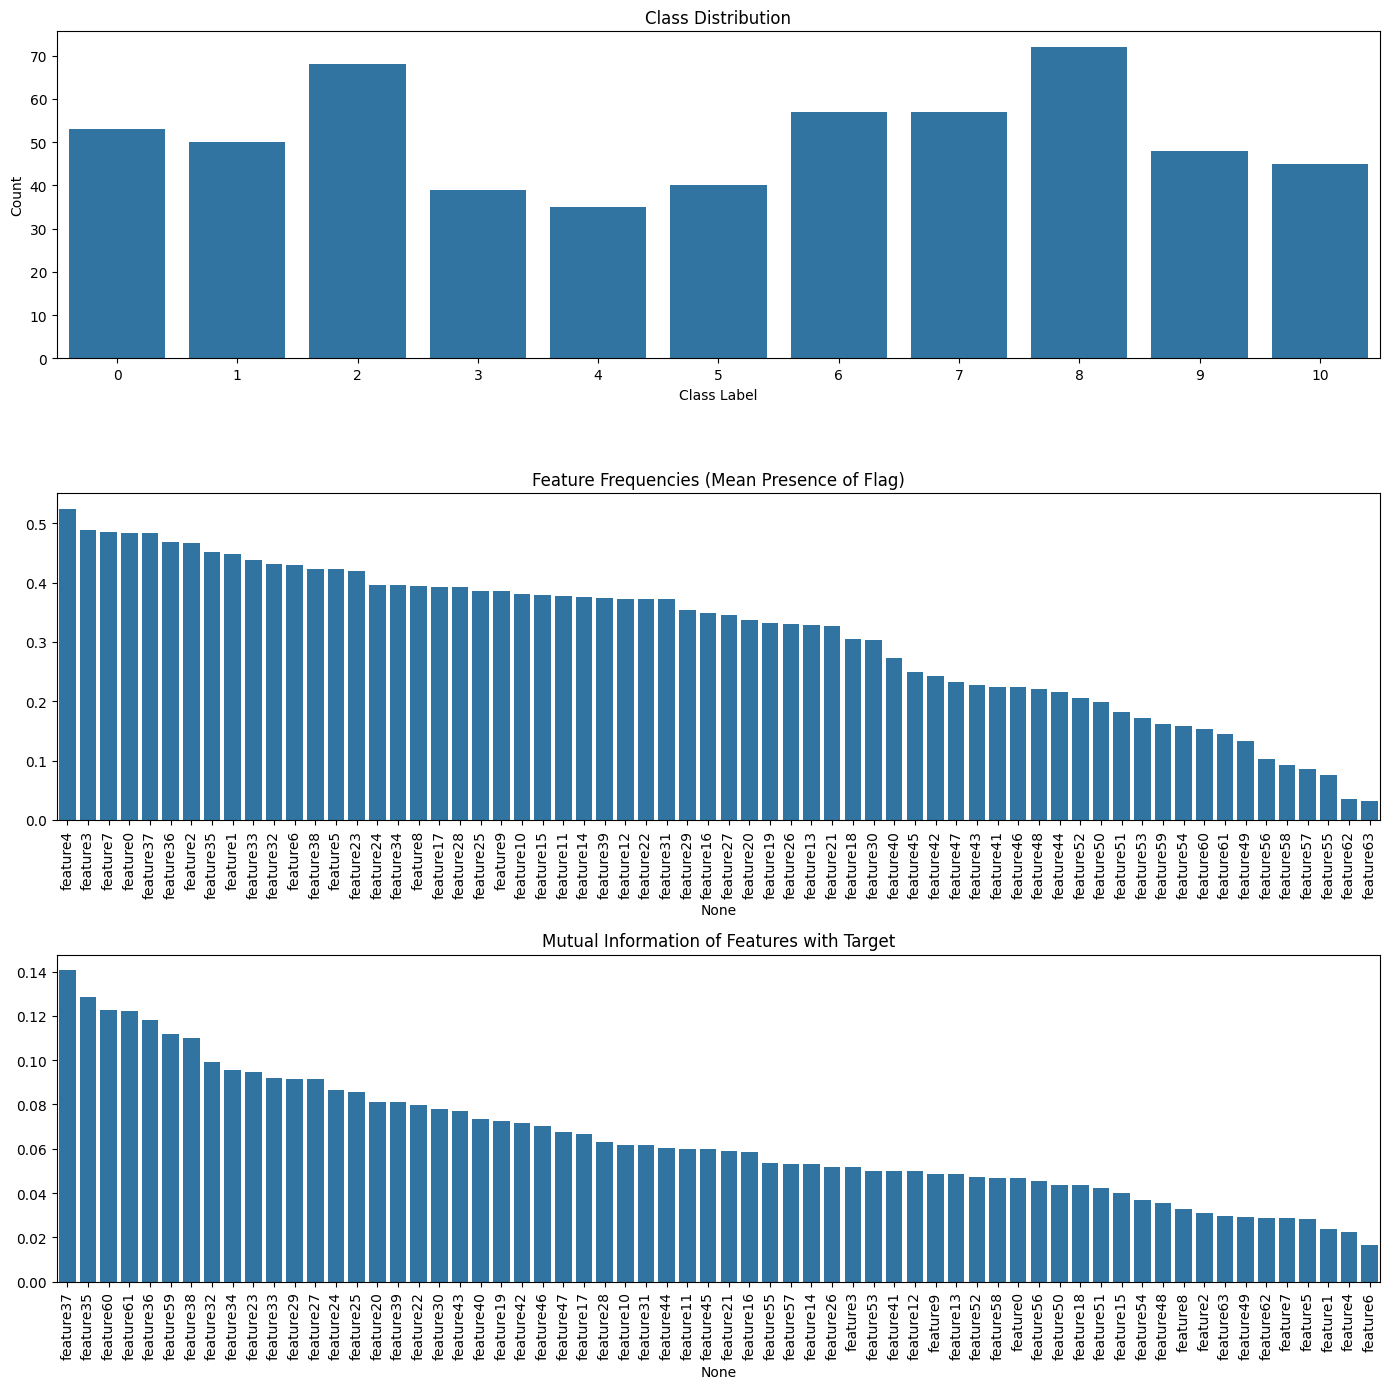

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(14, 14))

sns.barplot(x=class_counts.index, y=class_counts.values, ax=axs[0])
axs[0].set_title("Class Distribution")
axs[0].set_xlabel("Class Label")
axs[0].set_ylabel("Count")

sns.barplot(x=feature_freq.index, y=feature_freq.values, ax=axs[1])
axs[1].set_title("Feature Frequencies (Mean Presence of Flag)")
axs[1].tick_params(axis='x', rotation=90)

sns.barplot(x=mi_scores.index, y=mi_scores.values, ax=axs[2])
axs[2].set_title("Mutual Information of Features with Target")
axs[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [18]:
print("Top 10 Features by Mutual Information:\n")
print(mi_scores.head(10))

Top 10 Features by Mutual Information:

feature37    0.140600
feature35    0.128634
feature60    0.122592
feature61    0.122069
feature36    0.118272
feature59    0.111668
feature38    0.110185
feature32    0.099243
feature34    0.095524
feature23    0.094628
dtype: float64


In [6]:
feature_columns = [f'feature{i}' for i in range(64)]

## Baseline Modeling

In [7]:
X = train_df.drop(columns=["ID", "label"])
y = train_df["label"]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [9]:
print("--- Data Splitting Complete ---")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

print("\nClass distribution proportions in y_train:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nClass distribution proportions in y_val:")
print(y_val.value_counts(normalize=True).sort_index())

--- Data Splitting Complete ---
Shape of X_train: (451, 64)
Shape of X_val: (113, 64)
Shape of y_train: (451,)
Shape of y_val: (113,)

Class distribution proportions in y_train:
label
0     0.093126
1     0.088692
2     0.119734
3     0.068736
4     0.062084
5     0.070953
6     0.101996
7     0.101996
8     0.128603
9     0.084257
10    0.079823
Name: proportion, dtype: float64

Class distribution proportions in y_val:
label
0     0.097345
1     0.088496
2     0.123894
3     0.070796
4     0.061947
5     0.070796
6     0.097345
7     0.097345
8     0.123894
9     0.088496
10    0.079646
Name: proportion, dtype: float64


### Logistic Regression

In [9]:
log_reg_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,     
    multi_class='auto',
    random_state=42
)

In [12]:
log_reg_model.fit(X_train, y_train)
y_pred_val = log_reg_model.predict(X_val)

In [13]:
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.3274


In [14]:
print("\nClassification Report on Validation Set:")
print(classification_report(y_val, y_pred_val, zero_division=0))


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.12      0.10      0.11        10
           2       0.13      0.14      0.14        14
           3       0.42      0.62      0.50         8
           4       0.33      0.14      0.20         7
           5       0.17      0.12      0.14         8
           6       0.09      0.09      0.09        11
           7       0.38      0.55      0.44        11
           8       0.50      0.36      0.42        14
           9       0.25      0.20      0.22        10
          10       0.27      0.33      0.30         9

    accuracy                           0.33       113
   macro avg       0.31      0.32      0.31       113
weighted avg       0.32      0.33      0.31       113



Fine-Tune:


In [114]:
param_grid_log_reg = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': [None, 'balanced'],
        'max_iter': [1000, 2000]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'class_weight': [None, 'balanced'],
        'max_iter': [1000, 2000]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga'],
        'class_weight': [None, 'balanced'],
        'max_iter': [1000, 3000],
        'l1_ratio': [0.5]
    }
]

In [115]:
log_reg_for_tuning = LogisticRegression(random_state=42)

In [116]:
grid_search_log_reg = GridSearchCV(
    estimator=log_reg_for_tuning,
    param_grid=param_grid_log_reg,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [117]:
grid_search_log_reg.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [1000, 2000], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [1000, 2000], 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'], 'l1_ratio': [0.5],
                          'max_iter': [1000, 3000],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='accuracy', verbose=1)

In [118]:
print("\n--- Best Parameters Found for Logistic Regression ---")
print(grid_search_log_reg.best_params_)


--- Best Parameters Found for Logistic Regression ---
{'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


In [119]:
print("\n--- Evaluating Best Logistic Regression Model from GridSearchCV ---")
best_log_reg_model = grid_search_log_reg.best_estimator_


--- Evaluating Best Logistic Regression Model from GridSearchCV ---


In [120]:
y_pred_val_best_log_reg = best_log_reg_model.predict(X_val)

In [121]:
accuracy_best_log_reg = accuracy_score(y_val, y_pred_val_best_log_reg)
print(f"Validation Accuracy (Tuned Logistic Regression): {accuracy_best_log_reg:.4f}")

Validation Accuracy (Tuned Logistic Regression): 0.3540


In [122]:
print("\nClassification Report on Validation Set (Tuned Logistic Regression):")
print(classification_report(y_val, y_pred_val_best_log_reg, zero_division=0))


Classification Report on Validation Set (Tuned Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.00      0.00      0.00        10
           2       0.17      0.21      0.19        14
           3       0.40      0.50      0.44         8
           4       1.00      0.29      0.44         7
           5       0.00      0.00      0.00         8
           6       0.14      0.09      0.11        11
           7       0.54      0.64      0.58        11
           8       0.29      0.50      0.37        14
           9       0.30      0.30      0.30        10
          10       0.33      0.33      0.33         9

    accuracy                           0.35       113
   macro avg       0.35      0.34      0.32       113
weighted avg       0.33      0.35      0.32       113



### Naive Bayes

In [30]:
nb_model = BernoulliNB()

In [31]:
nb_model.fit(X_train, y_train)
y_pred_val_nb = nb_model.predict(X_val)

In [32]:
accuracy_nb = accuracy_score(y_val, y_pred_val_nb)
print(f"Validation Accuracy (Bernoulli NB): {accuracy_nb:.4f}")

Validation Accuracy (Bernoulli NB): 0.3805


In [33]:
print("\nClassification Report on Validation Set (Bernoulli NB):")
print(classification_report(y_val, y_pred_val_nb, zero_division=0))


Classification Report on Validation Set (Bernoulli NB):
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.00      0.00      0.00        10
           2       0.33      0.14      0.20        14
           3       0.56      0.62      0.59         8
           4       0.30      0.43      0.35         7
           5       0.67      0.25      0.36         8
           6       0.33      0.27      0.30        11
           7       0.54      0.64      0.58        11
           8       0.00      0.00      0.00        14
           9       0.27      0.70      0.39        10
          10       0.36      0.44      0.40         9

    accuracy                           0.38       113
   macro avg       0.36      0.40      0.36       113
weighted avg       0.34      0.38      0.34       113



Fine-Tune:

In [34]:
param_grid_bnb = {
    'alpha': np.logspace(-3, 1, 20)
}

In [35]:
param_grid_bnb_simple = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

In [36]:
bnb_for_tuning = BernoulliNB()

In [37]:
grid_search_bnb = GridSearchCV(
    estimator=bnb_for_tuning,
    param_grid=param_grid_bnb,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [38]:
grid_search_bnb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.33572147e+00, 3.79269019e+00, 6.15848211e+00, 1.00000000e+01])},
             scoring='accuracy', verbose=1)

In [39]:
print("\n--- Best Parameters Found for Bernoulli Naive Bayes ---")
print(grid_search_bnb.best_params_)


--- Best Parameters Found for Bernoulli Naive Bayes ---
{'alpha': np.float64(0.0026366508987303583)}


In [40]:
print("\n--- Evaluating Best Bernoulli Naive Bayes Model from GridSearchCV ---")
best_bnb_model = grid_search_bnb.best_estimator_


--- Evaluating Best Bernoulli Naive Bayes Model from GridSearchCV ---


In [41]:
y_pred_val_best_bnb = best_bnb_model.predict(X_val)

In [42]:
accuracy_best_bnb = accuracy_score(y_val, y_pred_val_best_bnb)
print(f"Validation Accuracy (Tuned Bernoulli Naive Bayes): {accuracy_best_bnb:.4f}")

Validation Accuracy (Tuned Bernoulli Naive Bayes): 0.3982


In [43]:
print("\nClassification Report on Validation Set (Tuned Bernoulli Naive Bayes):")
print(classification_report(y_val, y_pred_val_best_bnb, zero_division=0))


Classification Report on Validation Set (Tuned Bernoulli Naive Bayes):
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.27      0.30      0.29        10
           2       0.20      0.07      0.11        14
           3       0.56      0.62      0.59         8
           4       0.30      0.43      0.35         7
           5       0.67      0.25      0.36         8
           6       0.33      0.27      0.30        11
           7       0.58      0.64      0.61        11
           8       0.00      0.00      0.00        14
           9       0.27      0.70      0.39        10
          10       0.33      0.44      0.38         9

    accuracy                           0.40       113
   macro avg       0.39      0.42      0.38       113
weighted avg       0.37      0.40      0.36       113



Test:

In [164]:
feature_columns_for_test = [f'feature{i}' for i in range(64)]
X_test = test_df[feature_columns_for_test]

In [165]:
predictions_bnb = best_bnb_model.predict(X_test)

In [166]:
expected_ids = sample_submission_df['ID']

In [ ]:
submission_df_bnb = pd.DataFrame({'ID': expected_ids, 'label': predictions_bnb})

submission_df_bnb.to_csv('submission_tuned_bnb.csv', index=False)
print("submission_tuned_bnb.csv generated successfully.")

submission_tuned_bnb.csv generated successfully.


### Decision Tree

In [21]:
dt_model = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

In [22]:
dt_model.fit(X_train, y_train)
y_pred_val_dt = dt_model.predict(X_val)

In [23]:
accuracy_dt = accuracy_score(y_val, y_pred_val_dt)
print(f"Validation Accuracy (Decision Tree, max_depth=10): {accuracy_dt:.4f}")

Validation Accuracy (Decision Tree, max_depth=10): 0.2389


In [24]:
print("\nClassification Report on Validation Set (Decision Tree, max_depth=10):")
print(classification_report(y_val, y_pred_val_dt, zero_division=0))


Classification Report on Validation Set (Decision Tree, max_depth=10):
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.00      0.00      0.00        10
           2       0.15      0.14      0.15        14
           3       0.50      0.38      0.43         8
           4       0.33      0.29      0.31         7
           5       0.00      0.00      0.00         8
           6       0.17      0.09      0.12        11
           7       0.33      0.27      0.30        11
           8       0.07      0.07      0.07        14
           9       0.27      0.40      0.32        10
          10       0.09      0.11      0.10         9

    accuracy                           0.24       113
   macro avg       0.23      0.24      0.23       113
weighted avg       0.23      0.24      0.23       113



Fine-Tune:

In [47]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20], 
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],    
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], 
    'class_weight': [None, 'balanced'] 
}

In [48]:
dt_for_tuning = DecisionTreeClassifier(random_state=42)

In [49]:
grid_search_dt = GridSearchCV(
    estimator=dt_for_tuning,
    param_grid=param_grid_dt,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1 
)

In [51]:
grid_search_dt.fit(X_train, y_train)

Fitting 3 folds for each of 2560 candidates, totalling 7680 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02,
                                       0.025, 0.03],
                         'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy', verbose=1)

In [52]:
print("\n--- Best Parameters Found for Decision Tree ---")
print(grid_search_dt.best_params_)


--- Best Parameters Found for Decision Tree ---
{'ccp_alpha': 0.025, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [53]:
print("\n--- Evaluating Best Decision Tree Model from GridSearchCV ---")
best_dt_model = grid_search_dt.best_estimator_


--- Evaluating Best Decision Tree Model from GridSearchCV ---


In [54]:
y_pred_val_best_dt = best_dt_model.predict(X_val)    

In [55]:
accuracy_best_dt = accuracy_score(y_val, y_pred_val_best_dt)
print(f"Validation Accuracy (Tuned Decision Tree): {accuracy_best_dt:.4f}")

Validation Accuracy (Tuned Decision Tree): 0.3186


In [56]:
print("\nClassification Report on Validation Set (Tuned Decision Tree):")
print(classification_report(y_val, y_pred_val_best_dt, zero_division=0))


Classification Report on Validation Set (Tuned Decision Tree):
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.33      0.30      0.32        10
           2       0.00      0.00      0.00        14
           3       0.23      0.38      0.29         8
           4       0.17      0.29      0.21         7
           5       0.20      0.25      0.22         8
           6       0.33      0.09      0.14        11
           7       0.75      0.55      0.63        11
           8       0.25      0.14      0.18        14
           9       0.27      0.40      0.32        10
          10       0.14      0.33      0.20         9

    accuracy                           0.32       113
   macro avg       0.31      0.33      0.30       113
weighted avg       0.31      0.32      0.30       113



### SVM

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [45]:
svm_model = SVC(kernel='rbf', random_state=42, probability=True)

In [46]:
svm_model.fit(X_train_scaled, y_train)
y_pred_val_svm = svm_model.predict(X_val_scaled)

In [47]:
accuracy_svm = accuracy_score(y_val, y_pred_val_svm)
print(f"Validation Accuracy (Linear SVM): {accuracy_svm:.4f}")

Validation Accuracy (Linear SVM): 0.3717


In [48]:
print("\nClassification Report on Validation Set (Linear SVM):")
print(classification_report(y_val, y_pred_val_svm, zero_division=0))


Classification Report on Validation Set (Linear SVM):
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.30      0.30      0.30        10
           2       0.17      0.29      0.21        14
           3       0.57      0.50      0.53         8
           4       0.60      0.43      0.50         7
           5       0.00      0.00      0.00         8
           6       0.17      0.09      0.12        11
           7       0.78      0.64      0.70        11
           8       0.19      0.21      0.20        14
           9       0.28      0.50      0.36        10
          10       0.40      0.22      0.29         9

    accuracy                           0.37       113
   macro avg       0.38      0.37      0.37       113
weighted avg       0.37      0.37      0.36       113



Fine-Tune:

In [49]:
param_grid_rbf_svm = {
    'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 15, 25, 50, 75, 100],                
    'gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 1], 
    'kernel': ['rbf'],                     
    'class_weight': [None, 'balanced']   
}

In [50]:
rbf_svm_for_tuning = SVC(random_state=42)

In [51]:
grid_search_rbf_svm = GridSearchCV(
    estimator=rbf_svm_for_tuning,
    param_grid=param_grid_rbf_svm,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [52]:
grid_search_rbf_svm.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10,
                               15, 25, 50, 75, 100],
                         'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [53]:
print("\n--- Best Parameters Found for RBF SVM ---")
print(grid_search_rbf_svm.best_params_)


--- Best Parameters Found for RBF SVM ---
{'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [54]:
print("\n--- Evaluating Best RBF SVM Model from GridSearchCV ---")
best_rbf_svm_model = grid_search_rbf_svm.best_estimator_


--- Evaluating Best RBF SVM Model from GridSearchCV ---


In [55]:
y_pred_val_best_rbf_svm = best_rbf_svm_model.predict(X_val_scaled)

In [56]:
accuracy_best_rbf_svm = accuracy_score(y_val, y_pred_val_best_rbf_svm)
print(f"Validation Accuracy (Tuned RBF SVM): {accuracy_best_rbf_svm:.4f}")

Validation Accuracy (Tuned RBF SVM): 0.3805


In [57]:
print("\nClassification Report on Validation Set (Tuned RBF SVM):")
print(classification_report(y_val, y_pred_val_best_rbf_svm, zero_division=0))


Classification Report on Validation Set (Tuned RBF SVM):
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.36      0.40      0.38        10
           2       0.33      0.14      0.20        14
           3       0.40      0.50      0.44         8
           4       0.43      0.43      0.43         7
           5       0.00      0.00      0.00         8
           6       0.12      0.09      0.11        11
           7       0.73      0.73      0.73        11
           8       0.08      0.07      0.07        14
           9       0.29      0.80      0.42        10
          10       0.40      0.22      0.29         9

    accuracy                           0.38       113
   macro avg       0.36      0.39      0.35       113
weighted avg       0.35      0.38      0.35       113



Test:

In [170]:
feature_columns_for_test = [f'feature{i}' for i in range(64)]
X_test_full = test_df[feature_columns_for_test]

In [171]:
X_test_full_scaled = scaler.transform(X_test_full)

In [172]:
predictions_rbf_svm = best_rbf_svm_model.predict(X_test_full_scaled)

In [173]:
submission_df_rbf_svm = pd.DataFrame({'ID': expected_ids, 'label': predictions_rbf_svm})

submission_df_rbf_svm.to_csv('submission_tuned_rbf_svm.csv', index=False)
print("submission_tuned_rbf_svm.csv generated successfully.")

submission_tuned_rbf_svm.csv generated successfully.


### Random Forest

In [58]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1   
)

In [59]:
rf_model.fit(X_train, y_train)
y_pred_val_rf = rf_model.predict(X_val)

In [60]:
accuracy_rf = accuracy_score(y_val, y_pred_val_rf)
print(f"Validation Accuracy (Random Forest): {accuracy_rf:.4f}")

Validation Accuracy (Random Forest): 0.3009


In [61]:
print("\nClassification Report on Validation Set (Random Forest):")
print(classification_report(y_val, y_pred_val_rf, zero_division=0))


Classification Report on Validation Set (Random Forest):
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.12      0.10      0.11        10
           2       0.24      0.29      0.26        14
           3       0.44      0.50      0.47         8
           4       0.50      0.43      0.46         7
           5       0.33      0.25      0.29         8
           6       0.08      0.09      0.09        11
           7       0.50      0.45      0.48        11
           8       0.08      0.07      0.08        14
           9       0.22      0.20      0.21        10
          10       0.18      0.22      0.20         9

    accuracy                           0.30       113
   macro avg       0.31      0.31      0.31       113
weighted avg       0.29      0.30      0.30       113



Fine-Tune:

In [62]:
param_grid_rf = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

In [63]:
rf_for_tuning = RandomForestClassifier(random_state=42, n_jobs=-1)

In [64]:
grid_search_rf = GridSearchCV(
    estimator=rf_for_tuning,
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [65]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200,
                                          225, 250, 275, 300]},
             scoring='accuracy', verbose=1)

In [66]:
print("\n--- Best Parameters Found for Random Forest ---")
print(grid_search_rf.best_params_)


--- Best Parameters Found for Random Forest ---
{'class_weight': None, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [67]:
print("\n--- Evaluating Best Random Forest Model from GridSearchCV ---")
best_rf_model = grid_search_rf.best_estimator_


--- Evaluating Best Random Forest Model from GridSearchCV ---


In [68]:
y_pred_val_best_rf = best_rf_model.predict(X_val)

In [69]:
accuracy_best_rf = accuracy_score(y_val, y_pred_val_best_rf)
print(f"Validation Accuracy (Tuned Random Forest): {accuracy_best_rf:.4f}")

Validation Accuracy (Tuned Random Forest): 0.3805


In [70]:
print("\nClassification Report on Validation Set (Tuned Random Forest):")
print(classification_report(y_val, y_pred_val_best_rf, zero_division=0))


Classification Report on Validation Set (Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.56      0.91      0.69        11
           1       0.00      0.00      0.00        10
           2       0.25      0.29      0.27        14
           3       0.62      0.62      0.62         8
           4       0.60      0.43      0.50         7
           5       0.00      0.00      0.00         8
           6       0.14      0.09      0.11        11
           7       0.64      0.82      0.72        11
           8       0.18      0.21      0.19        14
           9       0.32      0.60      0.41        10
          10       0.40      0.22      0.29         9

    accuracy                           0.38       113
   macro avg       0.34      0.38      0.35       113
weighted avg       0.32      0.38      0.34       113



**Feature Importance**

In [71]:
importances = best_rf_model.feature_importances_
feature_names = np.array(feature_columns)
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

In [72]:
print("\nTop 20 most important features:")
print(feature_importance_df.head(20))


Top 20 most important features:
      feature  importance
61  feature61    0.039191
60  feature60    0.035180
37  feature37    0.034389
36  feature36    0.031681
59  feature59    0.027893
22  feature22    0.027687
32  feature32    0.023552
3    feature3    0.022809
35  feature35    0.022753
38  feature38    0.021840
33  feature33    0.021815
11  feature11    0.021271
24  feature24    0.020626
23  feature23    0.020121
17  feature17    0.019204
10  feature10    0.018975
43  feature43    0.018615
20  feature20    0.018507
28  feature28    0.017736
39  feature39    0.017712


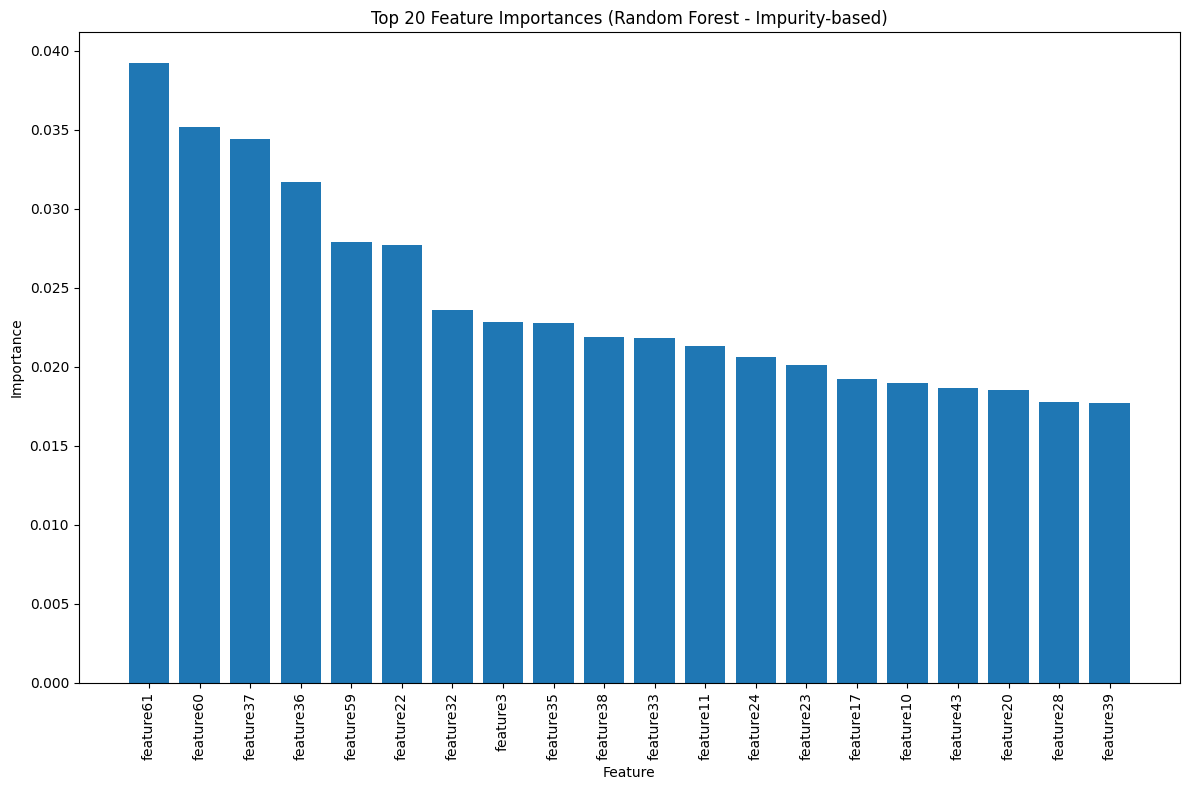

In [73]:
plt.figure(figsize=(12, 8))
top_n = 20
plt.title(f'Top {top_n} Feature Importances (Random Forest - Impurity-based)')
plt.bar(feature_importance_df['feature'].iloc[:top_n], feature_importance_df['importance'].iloc[:top_n])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [74]:
print("\nSummary of Feature Importances:")
print(f"Total number of features: {len(feature_names)}")
print(f"Number of features with importance > 0: {np.sum(importances > 0)}")
if not feature_importance_df.empty:
    print(f"Importance of least important feature (could be 0): {feature_importance_df['importance'].iloc[-1]:.4f}")
    print(f"Importance of most important feature: {feature_importance_df['importance'].iloc[0]:.4f}")
else:
    print("Feature importance DataFrame is empty.")


Summary of Feature Importances:
Total number of features: 64
Number of features with importance > 0: 64
Importance of least important feature (could be 0): 0.0035
Importance of most important feature: 0.0392


Test:

In [174]:
predictions_rf = best_rf_model.predict(X_test_full)

In [175]:
submission_df_rf = pd.DataFrame({'ID': expected_ids, 'label': predictions_rf})

submission_df_rf.to_csv('submission_tuned_rf.csv', index=False)
print("submission_tuned_rf.csv generated successfully.")

submission_tuned_rf.csv generated successfully.


### Voting Classifier

In [75]:
clf1_vot = grid_search_bnb.best_estimator_

In [76]:
best_svm_params = grid_search_rbf_svm.best_params_

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=best_svm_params.get('C', 1.0),
                gamma=best_svm_params.get('gamma', 'scale'),
                kernel='rbf',
                class_weight=best_svm_params.get('class_weight'),
                random_state=42,
                probability=True))
])
clf2_vot = pipeline_svm

In [77]:
best_rf_params = grid_search_rf.best_params_

clf3_vot = RandomForestClassifier(
    n_estimators=best_rf_params.get('n_estimators', 100),
    max_depth=best_rf_params.get('max_depth'),
    min_samples_split=best_rf_params.get('min_samples_split', 2),
    min_samples_leaf=best_rf_params.get('min_samples_leaf', 1),
    max_features=best_rf_params.get('max_features', 'sqrt'),
    class_weight=best_rf_params.get('class_weight'),
    random_state=42,
    n_jobs=-1
)

In [78]:
eclf_hard = VotingClassifier(
    estimators=[('bnb', clf1_vot), ('rbf_svm', clf2_vot), ('rf', clf3_vot)],
    voting='hard',
    n_jobs=-1
)

In [79]:
eclf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('bnb',
                              BernoulliNB(alpha=np.float64(0.0026366508987303583))),
                             ('rbf_svm',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svm',
                                               SVC(C=0.5,
                                                   class_weight='balanced',
                                                   probability=True,
                                                   random_state=42))])),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1)

In [80]:
print("\n--- Evaluating Voting Classifier (Hard Voting) ---")
y_pred_val_eclf_hard = eclf_hard.predict(X_val)


--- Evaluating Voting Classifier (Hard Voting) ---


In [81]:
accuracy_eclf_hard = accuracy_score(y_val, y_pred_val_eclf_hard)
print(f"Validation Accuracy (Voting Classifier - Hard): {accuracy_eclf_hard:.4f}")

Validation Accuracy (Voting Classifier - Hard): 0.3805


In [82]:
print("\nClassification Report on Validation Set (Voting Classifier - Hard):")
print(classification_report(y_val, y_pred_val_eclf_hard, zero_division=0))


Classification Report on Validation Set (Voting Classifier - Hard):
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.30      0.30      0.30        10
           2       0.27      0.21      0.24        14
           3       0.45      0.62      0.53         8
           4       0.38      0.43      0.40         7
           5       0.00      0.00      0.00         8
           6       0.14      0.09      0.11        11
           7       0.67      0.73      0.70        11
           8       0.11      0.07      0.09        14
           9       0.28      0.70      0.40        10
          10       0.33      0.22      0.27         9

    accuracy                           0.38       113
   macro avg       0.33      0.39      0.35       113
weighted avg       0.33      0.38      0.34       113



In [83]:
eclf_soft = VotingClassifier(
    estimators=[('bnb', clf1_vot), ('rbf_svm', clf2_vot), ('rf', clf3_vot)],
    voting='soft',
    n_jobs=-1
)

In [84]:
eclf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('bnb',
                              BernoulliNB(alpha=np.float64(0.0026366508987303583))),
                             ('rbf_svm',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svm',
                                               SVC(C=0.5,
                                                   class_weight='balanced',
                                                   probability=True,
                                                   random_state=42))])),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft')

In [85]:
print("\n--- Evaluating Voting Classifier (Soft Voting) ---")
y_pred_val_eclf_soft = eclf_soft.predict(X_val)


--- Evaluating Voting Classifier (Soft Voting) ---


In [86]:
accuracy_eclf_soft = accuracy_score(y_val, y_pred_val_eclf_soft)
print(f"Validation Accuracy (Voting Classifier - Soft): {accuracy_eclf_soft:.4f}")

Validation Accuracy (Voting Classifier - Soft): 0.3982


In [87]:
print("\nClassification Report on Validation Set (Voting Classifier - Soft):")
print(classification_report(y_val, y_pred_val_eclf_soft, zero_division=0))


Classification Report on Validation Set (Voting Classifier - Soft):
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.27      0.30      0.29        10
           2       0.33      0.14      0.20        14
           3       0.56      0.62      0.59         8
           4       0.30      0.43      0.35         7
           5       1.00      0.12      0.22         8
           6       0.33      0.27      0.30        11
           7       0.58      0.64      0.61        11
           8       0.00      0.00      0.00        14
           9       0.27      0.70      0.39        10
          10       0.36      0.44      0.40         9

    accuracy                           0.40       113
   macro avg       0.43      0.42      0.38       113
weighted avg       0.41      0.40      0.37       113



Test:

In [176]:
predictions_eclf_soft_64 = eclf_soft.predict(X_test_full)

In [177]:
submission_df_eclf_soft_64 = pd.DataFrame({'ID': expected_ids, 'label': predictions_eclf_soft_64})

submission_df_eclf_soft_64.to_csv('submission_soft_voter_64.csv', index=False)
print("submission_soft_voter_64.csv generated successfully.")

submission_soft_voter_64.csv generated successfully.


**Permutation Feature Importance**

In [88]:
perm_importance_result = permutation_importance(
    eclf_soft,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1
)

In [89]:
sorted_idx = perm_importance_result.importances_mean.argsort()[::-1]

In [90]:
perm_importance_df = pd.DataFrame({
    'feature': np.array(feature_columns)[sorted_idx],
    'importance_mean': perm_importance_result.importances_mean[sorted_idx],
    'importance_std': perm_importance_result.importances_std[sorted_idx]
})

In [91]:
print("\nTop 20 most important features (Permutation Importance):")
print(perm_importance_df.head(20))


Top 20 most important features (Permutation Importance):
      feature  importance_mean  importance_std
0   feature46         0.023894        0.006912
1   feature48         0.022124        0.007135
2   feature40         0.016814        0.006195
3   feature25         0.016814        0.009239
4   feature35         0.016814        0.008349
5   feature57         0.015929        0.006622
6   feature27         0.015929        0.009531
7   feature30         0.013274        0.004425
8   feature63         0.013274        0.008159
9   feature29         0.012389        0.011333
10  feature31         0.011504        0.007965
11  feature36         0.011504        0.009735
12  feature54         0.010619        0.003540
13  feature18         0.010619        0.008671
14  feature20         0.009735        0.008349
15  feature23         0.008850        0.006855
16   feature0         0.008850        0.008850
17  feature56         0.007965        0.010802
18   feature8         0.007965        0.006195
19

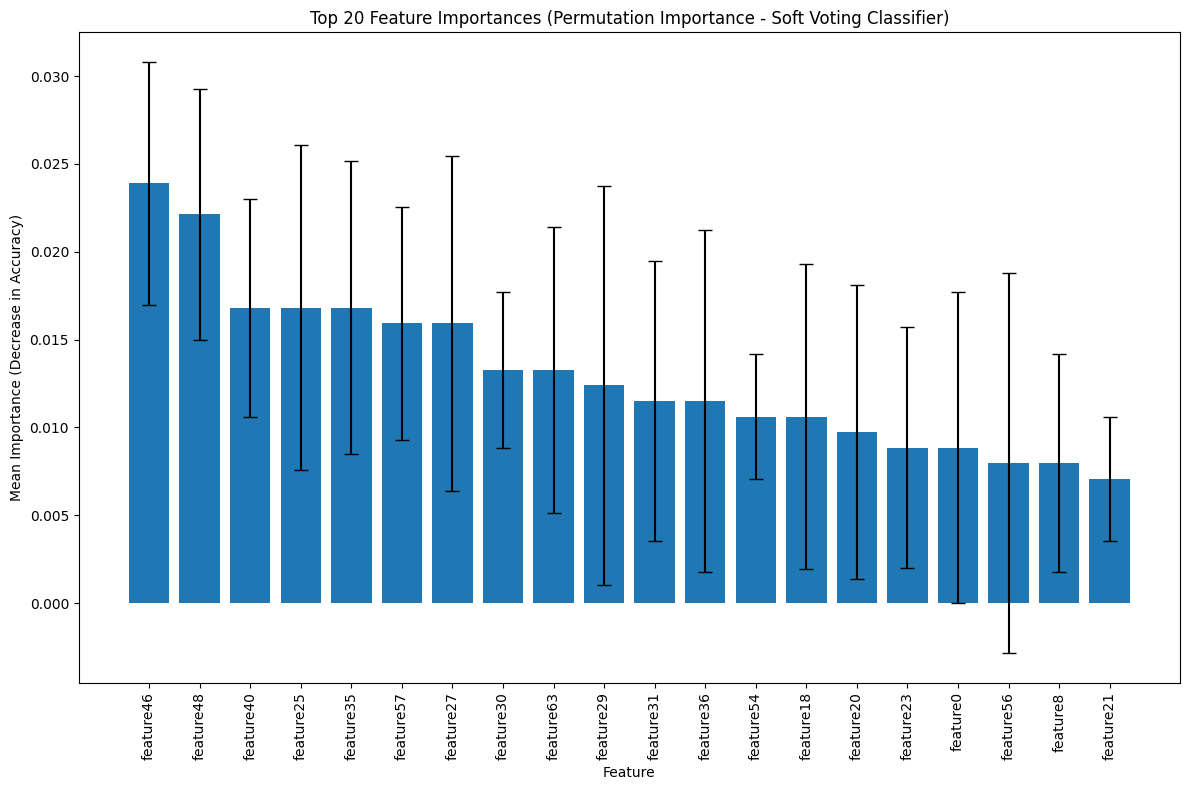

In [92]:
plt.figure(figsize=(12, 8))
top_n = 20
plt.title(f'Top {top_n} Feature Importances (Permutation Importance - Soft Voting Classifier)')
plt.bar(perm_importance_df['feature'][:top_n], perm_importance_df['importance_mean'][:top_n],
        yerr=perm_importance_df['importance_std'][:top_n], capsize=5)
plt.xlabel('Feature')
plt.ylabel('Mean Importance (Decrease in Accuracy)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [93]:
print("\nSummary of Permutation Importances:")
print(f"Total number of features: {len(feature_columns)}")
print(f"Number of features with mean importance > 0: {np.sum(perm_importance_result.importances_mean > 0)}")
if not perm_importance_df.empty:
    print(f"Mean importance of least impactful feature: {perm_importance_df['importance_mean'].iloc[-1]:.4f}")
    print(f"Mean importance of most impactful feature: {perm_importance_df['importance_mean'].iloc[0]:.4f}")
else:
    print("Permutation importance DataFrame is empty.")


Summary of Permutation Importances:
Total number of features: 64
Number of features with mean importance > 0: 48
Mean importance of least impactful feature: -0.0195
Mean importance of most impactful feature: 0.0239


Feature Selection

In [218]:
N = 30
top_n_features = perm_importance_df['feature'].head(N).tolist()
print(f"Top {N} features selected: {top_n_features}")

Top 30 features selected: ['feature46', 'feature48', 'feature40', 'feature25', 'feature35', 'feature57', 'feature27', 'feature30', 'feature63', 'feature29', 'feature31', 'feature36', 'feature54', 'feature18', 'feature20', 'feature23', 'feature0', 'feature56', 'feature8', 'feature21', 'feature26', 'feature60', 'feature32', 'feature14', 'feature39', 'feature15', 'feature13', 'feature16', 'feature34', 'feature43']


In [219]:
X_train_fs = X_train[top_n_features]
X_val_fs = X_val[top_n_features]

print(f"\nShape of X_train with feature selection: {X_train_fs.shape}")
print(f"Shape of X_val with feature selection: {X_val_fs.shape}")


Shape of X_train with feature selection: (451, 30)
Shape of X_val with feature selection: (113, 30)


In [220]:
clf1_fs = grid_search_bnb.best_estimator_

In [221]:
pipeline_svm_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=best_svm_params.get('C', 1.0),
                gamma=best_svm_params.get('gamma', 'scale'),
                kernel='rbf',
                class_weight=best_svm_params.get('class_weight'),
                random_state=42,
                probability=True))
])
clf2_fs = pipeline_svm_fs

In [222]:
clf3_fs = RandomForestClassifier(
    n_estimators=best_rf_params.get('n_estimators', 100),
    max_depth=best_rf_params.get('max_depth'),
    min_samples_split=best_rf_params.get('min_samples_split', 2),
    min_samples_leaf=best_rf_params.get('min_samples_leaf', 1),
    max_features=best_rf_params.get('max_features', 'sqrt'),
    class_weight=best_rf_params.get('class_weight'),
    random_state=42,
    n_jobs=-1
)

In [223]:
eclf_soft_fs = VotingClassifier(
    estimators=[('bnb', clf1_fs), ('rbf_svm', clf2_fs), ('rf', clf3_fs)],
    voting='soft',
    n_jobs=-1
)

In [225]:
eclf_soft_fs.fit(X_train_fs, y_train)
y_pred_val_eclf_soft_fs = eclf_soft_fs.predict(X_val_fs)

In [226]:
accuracy_eclf_soft_fs = accuracy_score(y_val, y_pred_val_eclf_soft_fs)
print(f"Validation Accuracy (Soft Voting - Feature Selection with Top {N} features): {accuracy_eclf_soft_fs:.4f}")

Validation Accuracy (Soft Voting - Feature Selection with Top 30 features): 0.4159


In [227]:
print("\nClassification Report on Validation Set (Soft Voting - Feature Selection):")
print(classification_report(y_val, y_pred_val_eclf_soft_fs, zero_division=0))


Classification Report on Validation Set (Soft Voting - Feature Selection):
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.38      0.30      0.33        10
           2       0.36      0.29      0.32        14
           3       0.60      0.75      0.67         8
           4       0.43      0.43      0.43         7
           5       0.33      0.12      0.18         8
           6       0.25      0.18      0.21        11
           7       0.57      0.73      0.64        11
           8       0.20      0.07      0.11        14
           9       0.35      0.60      0.44        10
          10       0.20      0.33      0.25         9

    accuracy                           0.42       113
   macro avg       0.39      0.43      0.40       113
weighted avg       0.39      0.42      0.39       113



Test:

In [228]:
X_test_fs = test_df[top_n_features]

In [229]:
predictions_eclf_soft_fs = eclf_soft_fs.predict(X_test_fs)

In [230]:
submission_df_eclf_soft_fs = pd.DataFrame({'ID': expected_ids, 'label': predictions_eclf_soft_fs})

submission_df_eclf_soft_fs.to_csv('submission_soft_voter_top30_fs.csv', index=False)
print("submission_soft_voter_top30_fs.csv generated successfully.")

submission_soft_voter_top30_fs.csv generated successfully.


SHAP

In [129]:
fitted_clf3_fs = eclf_soft_fs.named_estimators_['rf']

In [130]:
explainer_rf_fs = shap.TreeExplainer(fitted_clf3_fs, data=X_train_fs, feature_perturbation="interventional")

In [131]:
shap_values_rf_fs = explainer_rf_fs.shap_values(X_val_fs)

In [144]:
print(f"Shape of shap_values_rf_fs (should be 3D: samples, features, classes): {shap_values_rf_fs.shape if isinstance(shap_values_rf_fs, np.ndarray) else 'Not a NumPy array or unexpected structure'}")
print(f"Shape of X_val_fs: {X_val_fs.shape}")
print(f"Length of top_n_features: {len(top_n_features)}")

Shape of shap_values_rf_fs (should be 3D: samples, features, classes): (113, 30, 11)
Shape of X_val_fs: (113, 30)
Length of top_n_features: 30



--- SHAP Summary Plot (Global - RF component on selected features) ---


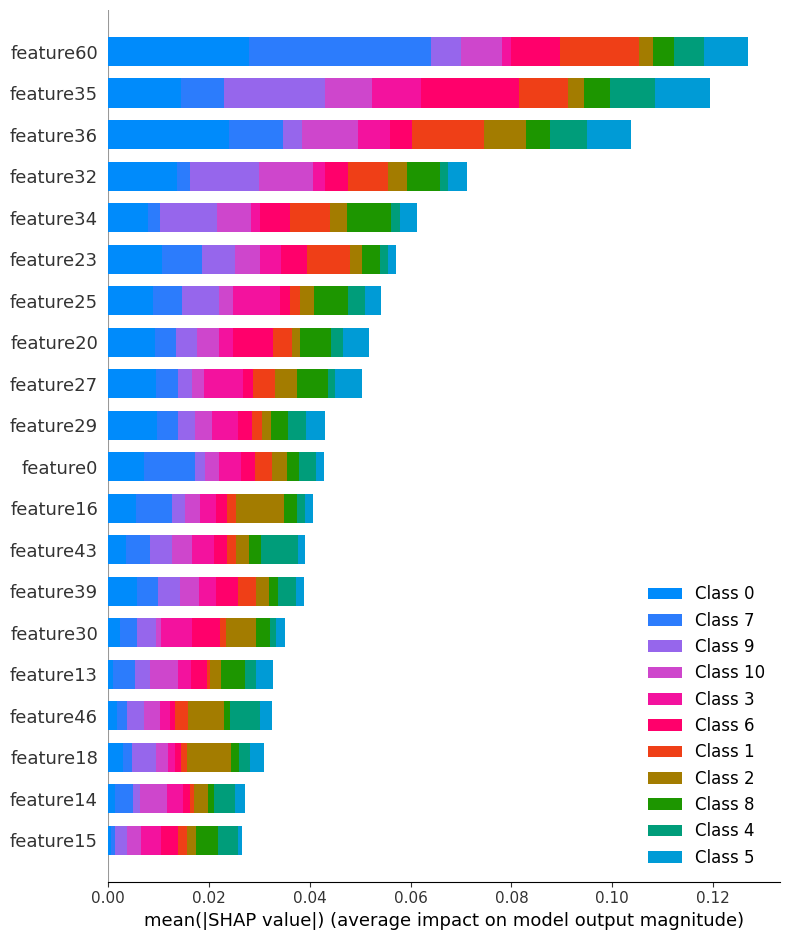

In [145]:
print("\n--- SHAP Summary Plot (Global - RF component on selected features) ---")
try:
    shap.summary_plot(shap_values_rf_fs, X_val_fs, feature_names=top_n_features, plot_type="bar")
    plt.show()
except Exception as e:
    print(f"Error generating global bar plot: {e}")
    print("You might need to aggregate shap_values_rf_fs for the global bar plot if it's 3D.")

In [146]:
class_labels_rf_fs = fitted_clf3_fs.classes_
print(f"\nRandom Forest component classes: {class_labels_rf_fs}")


Random Forest component classes: [ 0  1  2  3  4  5  6  7  8  9 10]


In [147]:
num_actual_classes = shap_values_rf_fs.shape[2] if isinstance(shap_values_rf_fs, np.ndarray) and shap_values_rf_fs.ndim == 3 else 0
classes_to_inspect_indices = [0, 3, 7]


--- SHAP Summary Plot for Class 0 (RF component) ---
Shape of SHAP values for class 0 being plotted: (113, 30)


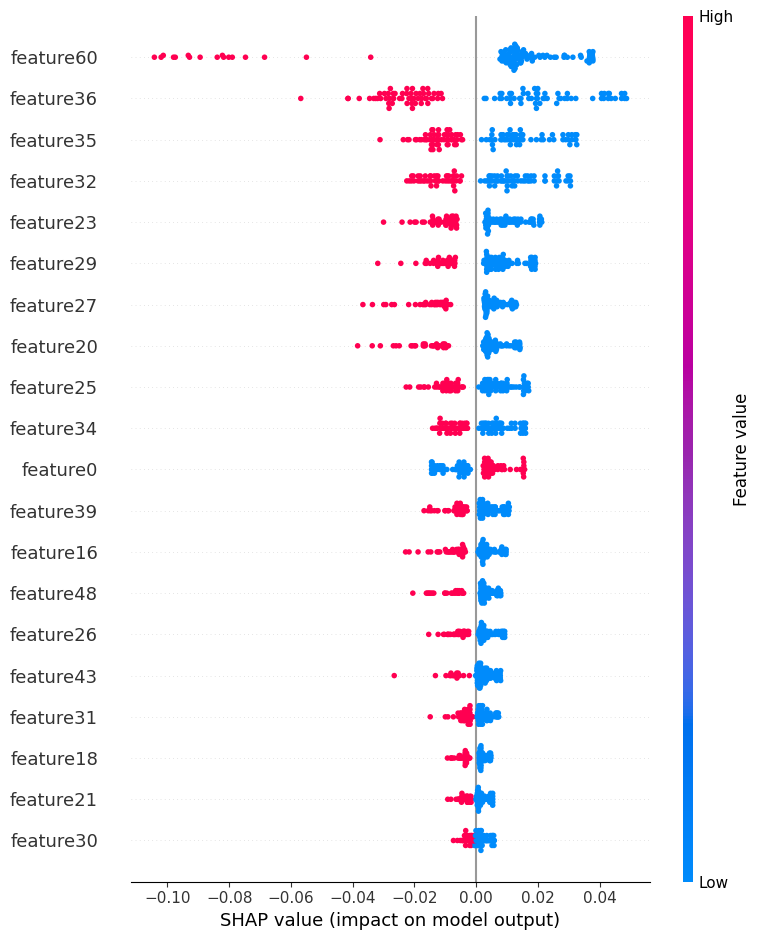

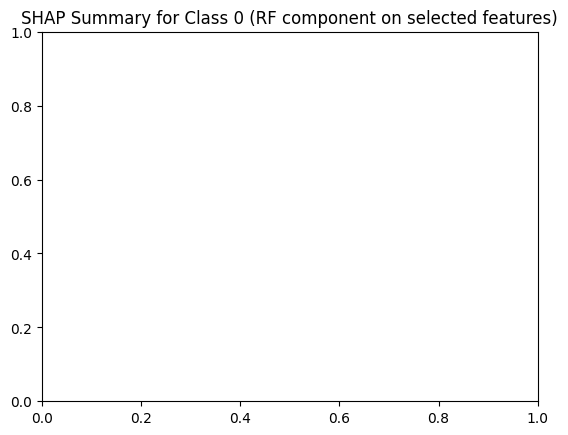


--- SHAP Summary Plot for Class 3 (RF component) ---
Shape of SHAP values for class 3 being plotted: (113, 30)


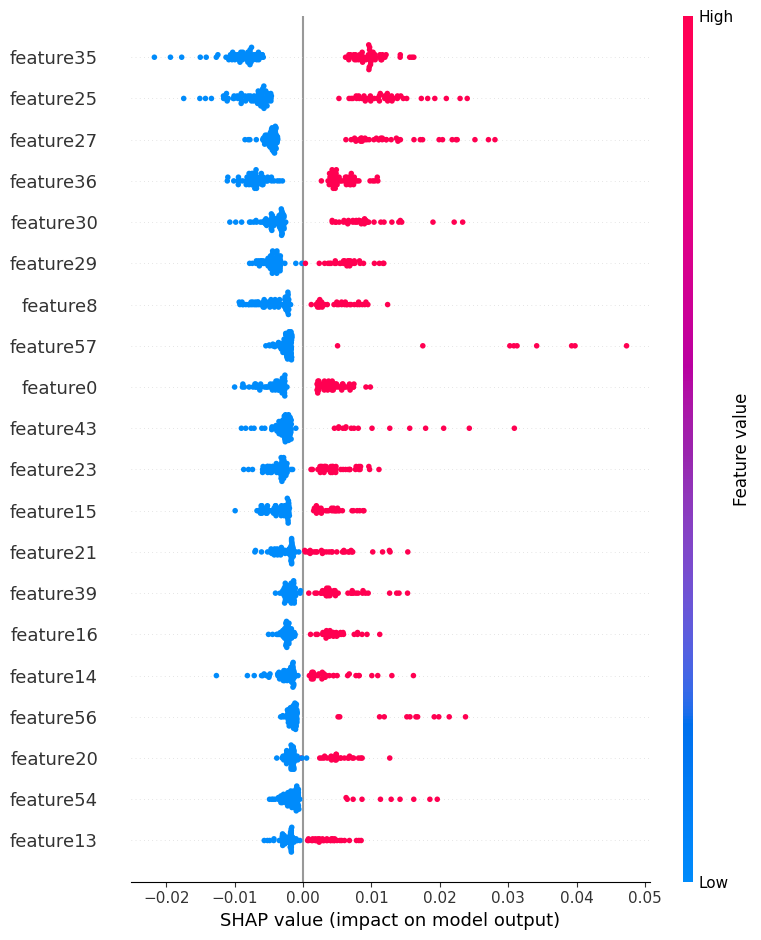

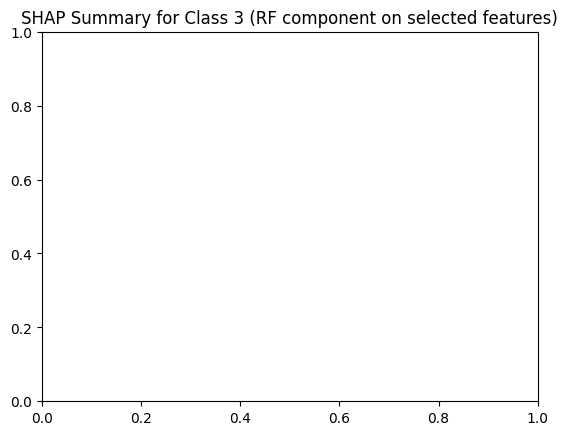


--- SHAP Summary Plot for Class 7 (RF component) ---
Shape of SHAP values for class 7 being plotted: (113, 30)


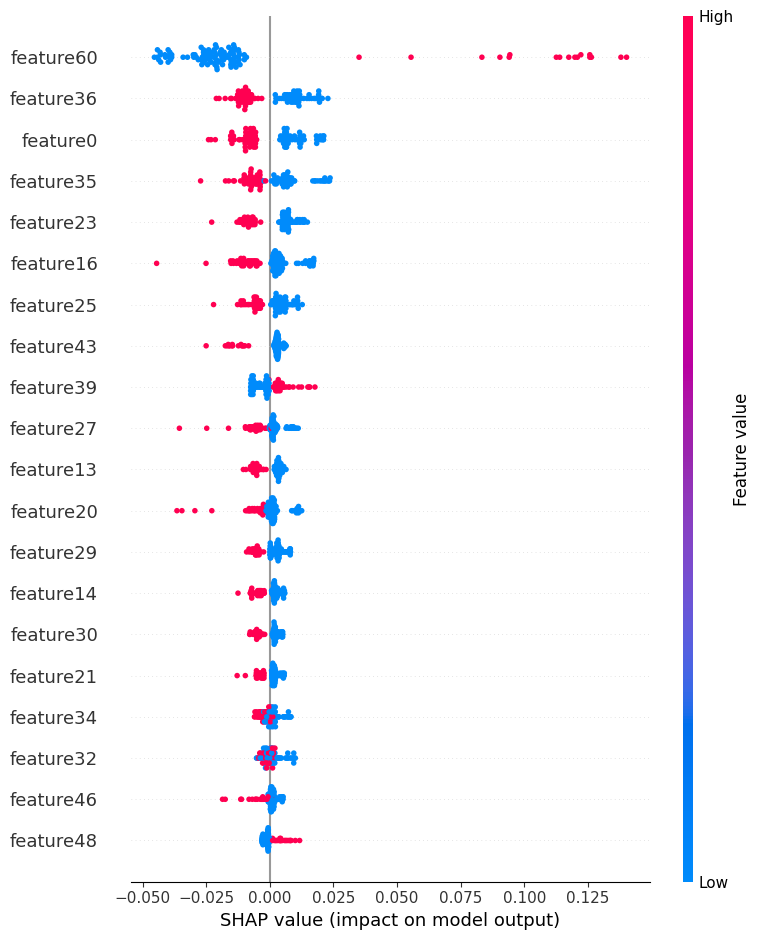

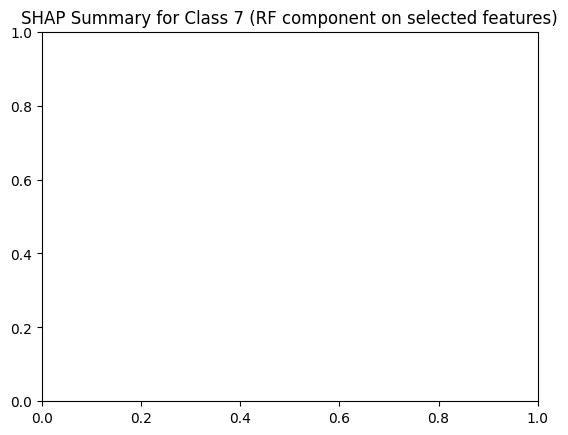

In [148]:
if num_actual_classes > 0:
    for class_idx_in_model_dim in classes_to_inspect_indices:
        if class_idx_in_model_dim < num_actual_classes:
            actual_class_label = class_labels_rf_fs[class_idx_in_model_dim]
            
            print(f"\n--- SHAP Summary Plot for Class {actual_class_label} (RF component) ---")

            shap_values_for_one_class = shap_values_rf_fs[:, :, class_idx_in_model_dim]

            print(f"Shape of SHAP values for class {actual_class_label} being plotted: {shap_values_for_one_class.shape}")
            
            shap.summary_plot(shap_values_for_one_class, X_val_fs, feature_names=top_n_features, plot_type="dot")
            plt.title(f"SHAP Summary for Class {actual_class_label} (RF component on selected features)")
            plt.show()
        else:
            print(f"Class index {class_idx_in_model_dim} is out of bounds for SHAP values class dimension.")
else:
    print("Could not determine the number of classes from shap_values_rf_fs for per-class plots.")

In [149]:
print("\n--- Mean Absolute SHAP Values per Class (Top 5 Features per Class - RF component) ---")
if isinstance(shap_values_rf_fs, np.ndarray) and shap_values_rf_fs.ndim == 3:
    for class_idx_in_model_dim in range(num_actual_classes):
        actual_class_label = class_labels_rf_fs[class_idx_in_model_dim]

        shap_values_for_one_class = shap_values_rf_fs[:, :, class_idx_in_model_dim]
        
        mean_abs_shap_class = np.abs(shap_values_for_one_class).mean(axis=0)
        
        if len(top_n_features) == len(mean_abs_shap_class):
            shap_importance_class_df = pd.DataFrame({
                'feature': top_n_features,
                'mean_abs_shap': mean_abs_shap_class
            }).sort_values(by='mean_abs_shap', ascending=False)
            print(f"\nTop 5 features for Class {actual_class_label}:")
            print(shap_importance_class_df.head(5))
        else:
            print(f"Mismatch in feature count for class {actual_class_label} when calculating mean abs SHAP. Expected {len(top_n_features)}, got {len(mean_abs_shap_class)}.")
else:
    print("Cannot calculate mean absolute SHAP values per class due to unexpected shap_values_rf_fs structure.")


--- Mean Absolute SHAP Values per Class (Top 5 Features per Class - RF component) ---

Top 5 features for Class 0:
      feature  mean_abs_shap
21  feature60       0.027922
11  feature36       0.024106
4   feature35       0.014510
22  feature32       0.013783
15  feature23       0.010637

Top 5 features for Class 1:
      feature  mean_abs_shap
21  feature60       0.015781
11  feature36       0.014277
4   feature35       0.009795
15  feature23       0.008463
28  feature34       0.007997

Top 5 features for Class 2:
      feature  mean_abs_shap
27  feature16       0.009521
13  feature18       0.008816
11  feature36       0.008370
0   feature46       0.007200
7   feature30       0.005886

Top 5 features for Class 3:
      feature  mean_abs_shap
4   feature35       0.009544
3   feature25       0.009349
6   feature27       0.007798
11  feature36       0.006465
7   feature30       0.006069

Top 5 features for Class 4:
      feature  mean_abs_shap
4   feature35       0.008803
11  feature36 